**1.1. Задача классификации экзопланет**

Цель задачи — определить, есть ли экзопланета у звезды, на основе данных временного ряда светового потока (яркости звезды). Данные представляют собой временные ряды, где снижение яркости может указывать на прохождение планеты перед звездой (транзит). Это задача бинарной классификации:

*   Класс 1: Звезда имеет экзопланету.

*   Класс 0: Звезда не имеет экзопланеты.

Проблемы:

*   Данные несбалансированы: положительных примеров (звезды с планетами) гораздо меньше.
*   Временные ряды содержат шум, который нужно учитывать.



**1.2. Что такое одномерная сверточная нейронная сеть (1D CNN)?**

1D CNN — это тип нейронной сети, предназначенный для обработки одномерных данных, таких как временные ряды или последовательности. Она использует сверточные слои для извлечения локальных признаков (например, паттернов во временном ряде) и пулинговые слои для уменьшения размерности.

Основные компоненты 1D CNN:

*   **Сверточный слой (Conv1D):** Применяет фильтры для извлечения локальных признаков.

*   **Пулинговый слой (MaxPool1D):** Уменьшает размерность данных, сохраняя важные признаки.

*   **Полносвязные слои (Dense):** Выполняют классификацию на основе извлеченных признаков.

*   **Нормализация (BatchNormalization):** Стабилизирует обучение, нормализуя активации.

*   **Dropout:** Предотвращает переобучение, случайным образом отключая нейроны.


**1.3. Keras и TensorFlow**

Keras — это высокоуровневый API для построения нейронных сетей, работающий поверх TensorFlow (или Theano). Keras упрощает создание моделей, позволяя сосредоточиться на архитектуре, а не на низкоуровневых вычислениях.

TensorFlow — это фреймворк для машинного обучения, который выполняет вычисления на основе графа.

**1.4. Основы временных рядов**

Временной ряд — это последовательность данных, измеренных через равные промежутки времени. В нашем случае это световой поток звезды, измеренный в разные моменты времени. Важные аспекты:

*   **Шум:** Временные ряды часто содержат высокочастотный шум, который нужно сгладить.

*   **Локальные паттерны:** Транзиты экзопланет создают характерные "провалы" в данных.

*   **Глобальные тренды:** Долгосрочные изменения в яркости звезды могут быть не связаны с планетами.

Методы обработки временных рядов:

*   **Нормализация:** Приведение данных к стандартному масштабу (нулевое среднее, единичная дисперсия).

*   **Сглаживание:** Устранение шума с помощью скользящего среднего или других фильтров.

*   **Аугментация:** Генерация новых примеров путем сдвига, добавления шума или масштабирования.

---


**2. Импортируем библиотеки**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import logging
import pandas as pd

# Настройка логирования для отслеживания процесса
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Фиксация случайного сида для воспроизводимости
np.random.seed(42)
tf.random.set_seed(42)

**2.1. Библиотеки для данных и визуализации**

*   **NumPy (np):** Работа с массивами и математические операции. Временные ряды хранятся как массивы NumPy.

*   **Matplotlib (plt):** Визуализация графиков (потери, точность, ROC-кривые).

*  **SciPy (uniform_filter1d):** Скользящее среднее для сглаживания временных рядов.

**2.2. Библиотеки для машинного обучения**

*  **Scikit-learn:**

 *  roc_curve, roc_auc_score: Для построения ROC-кривой и вычисления площади под ней (AUC).

 *  precision_recall_curve, f1_score: Для анализа Precision-Recall и F1-меры, важных при несбалансированных данных.

 *  train_test_split: Для разделения тестового набора на валидационный и тестовый.

*  **TensorFlow (tf):** Основной фреймворк для вычислений и Keras API.

*  **Keras:**
 *  Sequential: Простая модель для последовательного добавления слоев.

 *  Conv1D, MaxPool1D, Dense, Dropout, Flatten, BatchNormalization, Activation: Слои для построения сети.

 *  Adam: Оптимизатор на основе адаптивного градиентного спуска.

 *  EarlyStopping, ReduceLROnPlateau: Callbacks для управления обучением.

*  **Logging:** Логирование для отслеживания процесса и диагностики ошибок.

**2.3. Зачем нужны эти библиотеки?**
 *  **NumPy и SciPy:** Обработка временных рядов (нормализация, сглаживание).

 *  **Matplotlib:** Анализ результатов через графики.

 *  **Scikit-learn:** Оценка модели с учетом несбалансированности.

 *  **TensorFlow/Keras:** Построение и обучение нейронной сети.

 *  **Logging:** Упрощает отладку и мониторинг.

---


**3. Загрузка и предобработка данных**

**3.1. Загрузка данных**

In [ ]:
def load_data(train_path, test_path):
    logger.info("Загрузка данных...")
    try:
        # Загрузка обучающего набора
        raw_data = np.loadtxt(train_path, skiprows=1, delimiter=',')
        x_train = raw_data[:, 1:]  # Признаки (временные ряды)
        y_train = raw_data[:, 0] - 1  # Метки (0 или 1)

        # Загрузка тестового набора
        raw_data = np.loadtxt(test_path, skiprows=1, delimiter=',')
        x_test = raw_data[:, 1:]
        y_test = raw_data[:, 0] - 1

        logger.info(f"Обучающий набор: {x_train.shape}, Тестовый набор: {x_test.shape}")
        return x_train, y_train, x_test, y_test
    except Exception as e:
        logger.error(f"Ошибка при загрузке данных: {e}")
        raise

**Цель:** Загрузить данные из CSV-файлов (exoTrain.csv, exoTest.csv).

**np.loadtxt:** Читает данные, пропуская заголовки (skiprows=1) и используя запятую как разделитель.

**x_train, x_test:** Временные ряды (все колонки, кроме первой).

**y_train, y_test:** Метки классов (1 → 0, 2 → 1 для бинарной классификации).

**Логирование:** Сообщает о размерах наборов данных и обрабатывает ошибки.

**Форма данных:**

*   Например, x_train.shape = (5087, 3197): 5087 звезд, 3197 временных шагов.

*   y_train.shape = (5087,): метки для каждой звезды.

**Зачем это нужно?**
*   Разделение на признаки и метки подготавливает данные для обучения.

*   Обработка ошибок предотвращает сбои при неправильных файлах.



**3.2. предобработка данных**

In [ ]:
def preprocess_data(x_train, x_test, smoothing_windows=[50, 200]):
    logger.info("Предобработка данных...")

    # Нормализация: нулевое среднее и единичная дисперсия
    x_train = (x_train - np.mean(x_train, axis=1, keepdims=True)) / np.std(x_train, axis=1, keepdims=True)
    x_test = (x_test - np.mean(x_test, axis=1, keepdims=True)) / np.std(x_test, axis=1, keepdims=True)

    # Добавление сглаженных каналов
    x_train_channels = [x_train] + [uniform_filter1d(x_train, size=w, axis=1) for w in smoothing_windows]
    x_test_channels = [x_test] + [uniform_filter1d(x_test, size=w, axis=1) for w in smoothing_windows]

    # Объединение каналов
    x_train = np.stack(x_train_channels, axis=2)  # Форма: (n_samples, n_timesteps, n_channels)
    x_test = np.stack(x_test_channels, axis=2)

    logger.info(f"Форма данных после предобработки: train={x_train.shape}, test={x_test.shape}")
    return x_train, x_test

**Нормализация:**

*   Вычитается среднее (np.mean) и делится на стандартное отклонение (np.std) по каждому временному ряду.

*   keepdims=True: Сохраняет форму массива для корректных операций.

*   Результат: Каждый ряд имеет нулевое среднее и единичную дисперсию.

**Сглаживание:**

*   uniform_filter1d: Применяет скользящее среднее с окнами 50 и 200 шагов.

*   Создает два дополнительных канала, выделяющих паттерны на разных масштабах.

**Объединение каналов:**

*   np.stack: Объединяет исходный ряд и сглаженные версии в массив формы (n_samples, n_timesteps, 3) (3 канала: исходный, сглаженный 50, сглаженный 200).

**Логирование:** Сообщает о форме данных после обработки.

**Зачем это нужно?**

*   Нормализация стабилизирует обучение, уменьшая разброс значений.

*   Сглаживание подавляет шум и выделяет транзиты.

*   Многоканальный вход позволяет модели анализировать данные на разных масштабах, подобно RGB-каналам в изображениях.

---

**4. Аугментация данных и генератор батчей**

**4.1. Проблема несбалансированности**

Данные содержат мало положительных примеров (звезды с экзопланетами), что может привести к игнорированию редкого класса. Решение:

*   **Сбалансированные батчи:** Равное количество положительных и отрицательных примеров в каждом батче.

*   **Аугментация:** Генерация новых примеров путем преобразования данных.



**4.2. Генератор батчей**

In [ ]:
def batch_generator(x_train, y_train, batch_size=32, augment=True):
    half_batch = batch_size // 2
    pos_idx = np.where(y_train == 1)[0]
    neg_idx = np.where(y_train == 0)[0]

    while True:
        # Случайный выбор индексов
        np.random.shuffle(pos_idx)
        np.random.shuffle(neg_idx)

        # Формирование батча
        batch_idx = np.concatenate([pos_idx[:half_batch], neg_idx[:half_batch]])
        x_batch = x_train[batch_idx].copy()  # Копия для аугментации
        y_batch = y_train[batch_idx]

        if augment:
            for i in range(batch_size):
                # Сдвиг во времени
                shift = np.random.randint(x_batch.shape[1])
                x_batch[i] = np.roll(x_batch[i], shift, axis=0)

                # Добавление небольшого шума
                noise = np.random.normal(0, 0.01, x_batch[i].shape)
                x_batch[i] += noise

                # Случайное масштабирование амплитуды
                scale = np.random.uniform(0.9, 1.1)
                x_batch[i] *= scale

        yield x_batch, y_batch

**half_batch:** Половина батча (16 примеров) для каждого класса.

**pos_idx, neg_idx:** Индексы положительных и отрицательных примеров.

**Перемешивание:** Случайный выбор индексов для разнообразия батчей.

**Аугментация:**

*  Сдвиг во времени (np.roll): Имитирует разные фазы наблюдений.

*  Шум (np.random.normal): Добавляет гауссовский шум с малой амплитудой (σ=0.01).

*  Масштабирование (np.random.uniform): Изменяет амплитуду на ±10%.

**yield:** Генератор возвращает батчи по мере необходимости, экономя память.

**Зачем это нужно?**

*  Сбалансированные батчи предотвращают смещение модели в сторону отрицательного класса.

*  Аугментация увеличивает разнообразие данных, улучшая обобщение.

*  Генератор позволяет обрабатывать большие наборы данных, не загружая их целиком в память.

---

**5. Архитектура модели**

**5.1. Создание модели**

In [ ]:
def build_model(input_shape, dropout_rate=0.4):
    logger.info("Создание модели...")

    model = Sequential([
        # Первый сверточный блок
        Conv1D(filters=16, kernel_size=11, padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPool1D(pool_size=4),

        # Второй сверточный блок
        Conv1D(filters=32, kernel_size=11, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPool1D(pool_size=4),

        # Третий сверточный блок
        Conv1D(filters=64, kernel_size=11, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPool1D(pool_size=4),

        # Четвертый сверточный блок
        Conv1D(filters=128, kernel_size=11, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPool1D(pool_size=4),

        # Полносвязные слои
        Flatten(),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(64),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate / 2),

        Dense(1, activation='sigmoid')
    ])

    # Компиляция модели
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

**Sequential:** Модель с последовательным добавлением слоев.

**Сверточные блоки:**

*  filters: Увеличиваются (16, 32, 64, 128) для захвата более сложных признаков.

*  kernel_size=11: Фильтр охватывает 11 временных шагов.

*  padding='same': Сохраняет размерность выхода, добавляя нули по краям.

*  BatchNormalization: Нормализует активации перед ReLU.

*  Activation('relu'): Нелинейность для моделирования сложных паттернов.

*  MaxPool1D(pool_size=4): Уменьшает размерность в 4 раза, сохраняя важные признаки.

**Полносвязные слои:**

*  Flatten: Преобразует выход сверток в одномерный вектор.

*  Dense(128, 64): Обработка высокоуровневых признаков.

*  Dropout(0.4, 0.2): Предотвращает переобучение.

*  Dense(1, activation='sigmoid'): Выдает вероятность класса 1.

**Компиляция:**

*  optimizer=Adam(1e-4): Адаптивный оптимизатор с умеренной скоростью обучения.

*  loss='binary_crossentropy': Подходит для бинарной классификации.

*  metrics: Точность и AUC для оценки производительности.

**Почему такая архитектура?**

*  Глубокая сеть с четырьмя сверточными блоками эффективно извлекает признаки на разных уровнях.

*  padding='same' предотвращает потерю информации на краях.

*  BatchNormalization и Dropout стабилизируют обучение и снижают переобучение.

*  Разделение BatchNormalization и Activation повышает гибкость.

---

**6. Обучение модели**

**6.1. Обучение**

In [ ]:
def train_model(model, x_train, y_train, x_test, y_test, batch_size=32, epochs=50):
    logger.info("Начало обучения модели...")

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )

    # Разделение тестового набора на валидационный и тестовый
    x_val, x_test, y_val, y_test = train_test_split(
        x_test, y_test, test_size=0.5, stratify=y_test, random_state=42
    )

    # Обучение
    history = model.fit(
        batch_generator(x_train, y_train, batch_size, augment=True),
        steps_per_epoch=len(x_train) // batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return history, x_test, y_test

**Callbacks:**

*  EarlyStopping: Останавливает обучение, если валидационные потери не улучшаются 10 эпох, восстанавливая лучшие веса.

*  ReduceLROnPlateau: Уменьшает скорость обучения в 2 раза, если потери не улучшаются 5 эпох.

**Разделение данных:**

*  Тестовый набор делится на валидационный и тестовый (train_test_split, stratify=y_test для сохранения баланса классов).

**Обучение:**

*  Используется генератор батчей с аугментацией.

*  steps_per_epoch: Количество батчей на эпоху.

*  validation_data: Оценка на валидационной выборке после каждой эпохи.

**Выход:** История обучения (history) и финальные тестовые данные.

**Зачем это нужно?**

*  EarlyStopping предотвращает переобучение.

*  ReduceLROnPlateau адаптирует скорость обучения, ускоряя сходимость.

*  Валидационная выборка дает более надежную оценку производительности.

---

**7. Оценка модели**

**7.1. Оценка**

In [ ]:
def evaluate_model(model, x_test, y_test, history):
    logger.info("Оценка модели...")

    # Визуализация метрик
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Предсказания
    y_pred = model.predict(x_test).ravel()

    # ROC-кривая
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Precision-Recall кривая
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = np.max(f1_scores)

    plt.figure()
    plt.plot(recall, precision, label=f'Best F1 = {best_f1:.2f} at threshold = {best_threshold:.2f}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    # Анализ ошибок
    y_pred_binary = (y_pred > best_threshold).astype(int)
    false_positives = np.where((y_pred_binary == 1) & (y_test == 0))[0]

    if len(false_positives) > 0:
        logger.info(f"Найдено {len(false_positives)} ложноположительных примеров")
        for idx in false_positives[:3]:  # Показать первые 3
            plt.figure()
            plt.plot(x_test[idx, :, 0], label='Original Signal')
            plt.title(f'False Positive Example {idx}')
            plt.legend()
            plt.show()

    return auc_score, best_f1, best_threshold

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 3197, 16)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3197, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 3197, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 799, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 799, 32)             │           5,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 799, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 799, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 199, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 199, 64)             │          22,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 199, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 199, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 49, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 49, 128)             │          90,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 49, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 49, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 325,825 (1.24 MB)

 Trainable params: 324,961 (1.24 MB)

 Non-trainable params: 864 (3.38 KB)

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 43s 217ms/step - accuracy: 0.6185 - auc: 0.6590 - loss: 0.6812 - val_accuracy: 0.0912 - val_auc: 0.9403 - val_loss: 1.1778 - learning_rate: 1.0000e-04
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 31s 196ms/step - accuracy: 0.7195 - auc: 0.8011 - loss: 0.5406 - val_accuracy: 0.3158 - val_auc: 0.9580 - val_loss: 0.9992 - learning_rate: 1.0000e-04
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - accuracy: 0.7629 - auc: 0.8542 - loss: 0.4768 - val_accuracy: 0.5895 - val_auc: 0.9758 - val_loss: 0.6564 - learning_rate: 1.0000e-04
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 0.8208 - auc: 0.8975 - loss: 0.4081 - val_accuracy: 0.7965 - val_auc: 0.9669 - val_loss: 0.4668 - learning_rate: 1.0000e-04
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.8934 - auc: 0.9549 - loss: 0.2904 - val_accuracy: 0.3088 - val_auc: 0.9374 - val_loss: 1.5934 - learning_rate: 1.0000e-04
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 31s 1

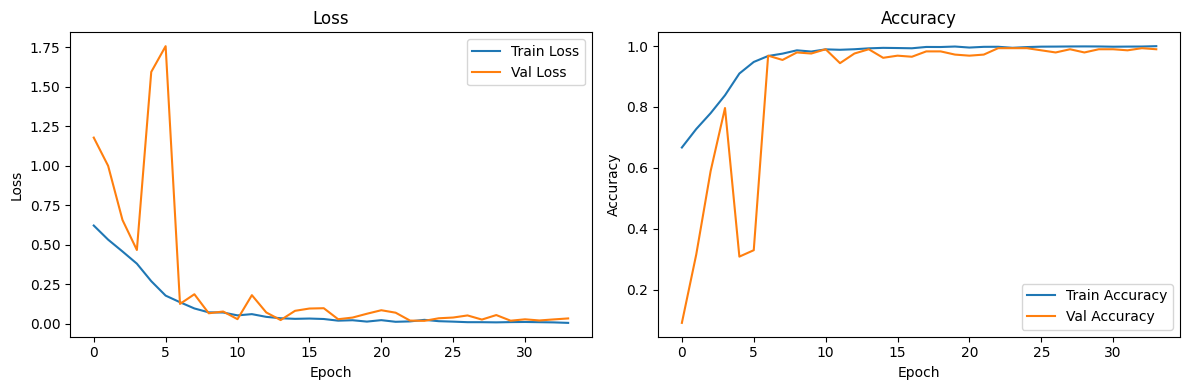

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


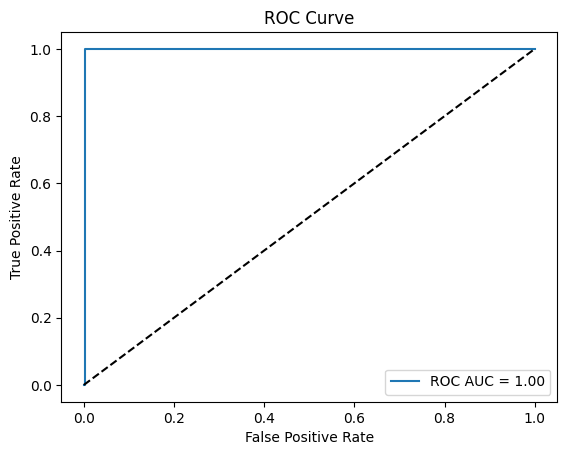

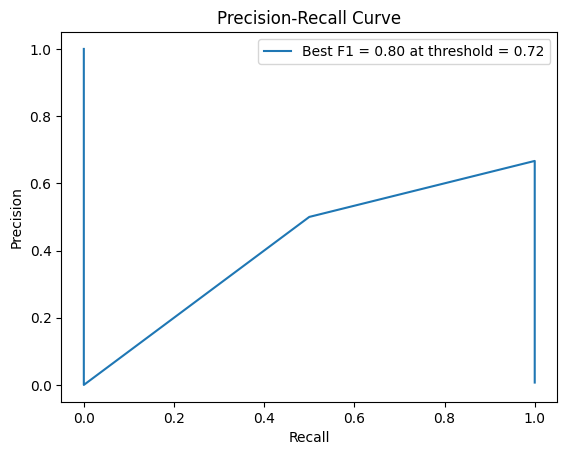

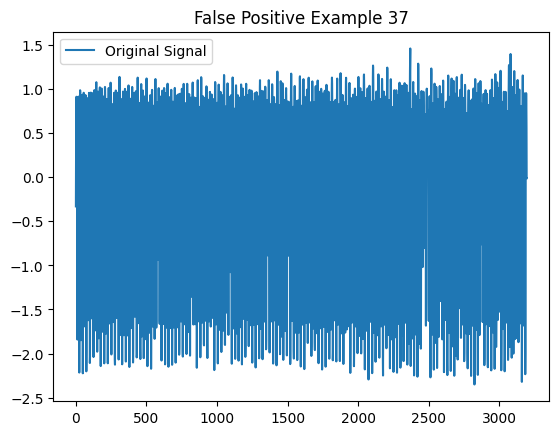

In [ ]:
def main():
    # Пути к данным
    train_path = '/content/drive/MyDrive/Data/exoTrain.csv'
    test_path = '/content/drive/MyDrive/Data/exoTest.csv'

    # Загрузка данных
    x_train, y_train, x_test, y_test = load_data(train_path, test_path)

    # Предобработка
    x_train, x_test = preprocess_data(x_train, x_test, smoothing_windows=[50, 200])

    # Создание модели
    model = build_model(input_shape=x_train.shape[1:])
    model.summary()

    # Обучение
    history, x_test, y_test = train_model(model, x_train, y_train, x_test, y_test)

    # Оценка
    auc_score, best_f1, best_threshold = evaluate_model(model, x_test, y_test, history)

    logger.info(f"Финальные метрики: AUC={auc_score:.2f}, F1={best_f1:.2f}, Threshold={best_threshold:.2f}")

if __name__ == "__main__":
    main()